<a href="https://colab.research.google.com/github/Bo-kyoung/practices/blob/main/VGG16_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
  print("cuda")
  torch.cuda.manual_seed_all(777)

transform = transforms.Compose(
    [transforms.ToTensor()
    ,transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])


cuda


In [2]:
learning_rate = 0.01
training_epochs = 74
batch_size = 256

In [3]:
CIFAR100_train = dsets.CIFAR100(root='data/',train = True, download=True, transform=transform)
CIFAR100_test = dsets.CIFAR100(root='d0ta/', train=False, download = True, transform=transform)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting d0ta/cifar-100-python.tar.gz to d0ta/


In [4]:
data_loader = DataLoader(dataset = CIFAR100_train, batch_size = batch_size, shuffle = True,drop_last = True)
test_loader = DataLoader(dataset = CIFAR100_test, batch_size = batch_size, shuffle = False,drop_last = True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])
0


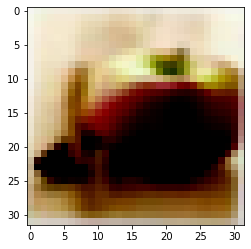

In [7]:
def custom_imshow(img):
  img = img.numpy()
  plt.imshow(np.transpose(img,(1,2,0)))
  plt.show()


X,Y = CIFAR100_train[2]
print(X.shape)
print(Y)

custom_imshow(X)

In [ ]:
len(CIFAR100_train.classes)

100

In [8]:
class VGG16(nn.Module):
  def __init__(self, init_weights = True):
    super(VGG16, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =128,out_channels = 128,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =256,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =256,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels =256,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
        )
    
    #self.avg_pool = nn.AvgPool2d(7)

    if init_weights: 
      self._initialize_weights()
    
    self.classfier = nn.Sequential(
    nn.Linear(4*4*512,4096),
    nn.ReLU(True),
    nn.Dropout(0.5), 
    nn.Linear(4096,4096),
    nn.ReLU(True),
    nn.Dropout(0.5), 
    nn.Linear(4096,100)
    )
  
  


  def forward(self, x):
    out = self.conv(x)
  ## out = self.avg_pool(out)
    out = out.view(out.size(0),-1)
    out = self.classfier(out)
    return out
#https://blog.naver.com/PostView.naver?blogId=mmmy2513&logNo=222300615187
#https://blogofth-lee.tistory.com/265?category=872318
  def _initialize_weights(self): 
    for m in self.modules(): 
      if isinstance(m, nn.Conv2d): 
        nn.init.kaiming_uniform_(m.weight) 
        if m.bias is not None: 
          nn.init.constant_(m.bias, 0) 
      elif isinstance(m, nn.BatchNorm2d): 
        nn.init.constant_(m.weight, 1) 
        nn.init.constant_(m.bias, 0) 
      elif isinstance(m, nn.Linear): 
        nn.init.kaiming_uniform_(m.weight) 
        nn.init.constant_(m.bias, 0)




In [11]:
model = VGG16().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(),lr = 0.01, momentum = 0.9)
lr_sche = optim.lr_scheduler.OneCycleLR

In [12]:
total_batch = len(data_loader)
print(total_batch)

195


In [13]:
loss_graph = []
training_epochs = 30
correct = 0
total = 0
acc = []

for epoch in range(training_epochs):
    avg_cost = 0
    running_loss = 0.0

    for i , data in enumerate(data_loader, 0):
      X, Y = data
      X = X.to(device)
      Y = Y.to(device)
     
      hypothesis = model(X)
      cost = criterion(hypothesis, Y)
      optimizer.zero_grad()
      cost.backward()
      optimizer.step()


      avg_cost += cost / total_batch
    
    loss_graph.append(avg_cost)
    with torch.no_grad():
      for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data,1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      cor = 100*correct/total
      acc.append(cor)
    print('acc: %d %%' % (100*correct/total))
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))



acc: 5 %
[Epoch:    1] cost = 4.42130709
acc: 8 %
[Epoch:    2] cost = 3.95593262
acc: 10 %
[Epoch:    3] cost = 3.65790081
acc: 12 %
[Epoch:    4] cost = 3.38680506
acc: 15 %
[Epoch:    5] cost = 3.12943244
acc: 16 %
[Epoch:    6] cost = 2.901443
acc: 19 %
[Epoch:    7] cost = 2.66965771
acc: 20 %
[Epoch:    8] cost = 2.46189809
acc: 22 %
[Epoch:    9] cost = 2.26135683
acc: 24 %
[Epoch:   10] cost = 2.06499743
acc: 25 %
[Epoch:   11] cost = 1.86305308
acc: 26 %
[Epoch:   12] cost = 1.64206862
acc: 27 %
[Epoch:   13] cost = 1.44729459
acc: 28 %
[Epoch:   14] cost = 1.22471309
acc: 29 %
[Epoch:   15] cost = 1.02489257
acc: 30 %
[Epoch:   16] cost = 0.86680299
acc: 30 %
[Epoch:   17] cost = 0.708104908
acc: 31 %
[Epoch:   18] cost = 0.581861794
acc: 31 %
[Epoch:   19] cost = 0.488286465
acc: 32 %
[Epoch:   20] cost = 0.406813383
acc: 32 %
[Epoch:   21] cost = 0.351230651
acc: 32 %
[Epoch:   22] cost = 0.304827213
acc: 33 %
[Epoch:   23] cost = 0.268230408
acc: 33 %
[Epoch:   24] cost = 

In [ ]:
loss_graph_2 = torch.as_tensor(loss_graph,device='cpu')

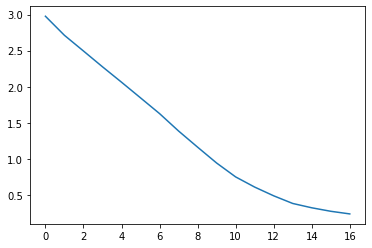

In [ ]:
plt.plot(loss_graph_2)

<function matplotlib.pyplot.show>

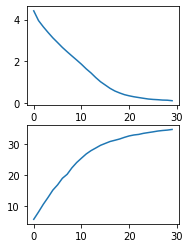

In [14]:
loss_graph_2 = torch.as_tensor(loss_graph,device='cpu')
acc_2 = torch.as_tensor(acc,device='cpu')
plt.subplot(222)
plt.plot(loss_graph_2)
plt.subplot(224)
plt.plot(acc_2)
plt.show



In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data,1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('acc: %d %%' % (100*correct/total))

NameError: ignored